In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pendulum

# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how value iteration and Q-learning work, their limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Part 1 - Value iteration with a model
In the first part, we will implement the value iteration algorithm, which requires us to have a model of the robot dynamics, i.e. we need to be able to know the next state $x_{n+1}$ given $(x_n, u_n)$. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$.

In [3]:
# we can create a robot
robot = pendulum.Pendulum()

# assume we set theta and dtheta = 0 and u = -5, we can get the next state using
x = np.array([0,0])
u = -5
x_next = robot.next_state(x, u)

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [4]:
x_next

array([ 6.26078821, -0.49412629])

# Q1.1 &Q1.2
1. Write a function that implements the value iteration algorithm ```value_iteration(robot)``` that takes as an input the robot model (to use ```robot.next_state```) and returns two 50x50 arrays, one for the value function and one for the optimal policy.

2. Compute the optimal value function and policy when $u$ has three possible value $\{-5, 0, 5\}$ (plot these functions as 2D images - cf. below). How many iterations of the value iteration algorithm are necessary to converge?(assume convergence when no value changes more than $10^{-2}$ after an iteration and initialize the first guess for the value function to 0). Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position?

In [5]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = (x[0]-np.pi)**2 + 0.01*x[1]**2 + 0.0001*u**2
    return res
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)

In [6]:
class Value_iter_solver:
    def __init__(self,robot, costfn = cost, actions=None, max_iters=400, sparse_loss=False):
        self.robot:pendulum = robot
        if actions is None:
            actions = [-5, 0, 5]
        self.action_list = np.array(actions)
        self.alpha = 0.99
        self.stop_loss = 1e-2
        self.max_iters = max_iters
        self.sparse_loss = sparse_loss
        self.costfn = costfn
        self.discretized_theta = discretized_theta
        self.discretized_theta_dot = discretized_thetadot
        self.space_shape = [len(discretized_theta),len(discretized_thetadot)]
        self.value = np.zeros(self.space_shape)
        self.policy = np.zeros(self.space_shape)
        self.make_state_transfer_table()

    def make_state_transfer_table(self):
        table_shape = [self.space_shape[0],self.space_shape[1],len(self.action_list),len(self.space_shape)]
        table = np.zeros(table_shape,dtype=np.int32)
        for i,theta in enumerate(self.discretized_theta):
            for j,v in enumerate(self.discretized_theta_dot):
                for k,u in enumerate(self.action_list):
                    next_state = self.robot.next_state([theta,v],u)
                    next_id = self.get_ids_by_state_value(next_state)
                    table[i,j,k,:] = np.array(next_id)
        self.state_transfer_table = table



    def get_state_by_ids(self,ids):
        thetaid,vid = ids[0],ids[1]
        theta = self.discretized_theta[thetaid]
        v = self.discretized_theta_dot[vid]
        return np.array([theta,v])

    def get_ids_by_state_value(self,x):
        theta,v = x[0],x[1]
        theta_id = np.argmin(np.abs(self.discretized_theta - theta))
        v_id = np.argmin(np.abs(self.discretized_theta_dot - v))
        return [theta_id,v_id]

    def value_iteration(self):
        J_last = np.zeros(self.space_shape)
        for i in range(self.max_iters):
            J_new = np.zeros_like(J_last)
            for j in range(self.space_shape[0]):
                for k in range(self.space_shape[1]):
                    score = np.zeros(len(self.action_list))
                    for l, u in enumerate(self.action_list):

                        theta = self.discretized_theta[j]
                        dot = self.discretized_theta_dot[k]

                        next_state_id = self.state_transfer_table[j,k,l,:]

                        score_next = J_last[next_state_id[0],next_state_id[1]]
                        cost_score = self.costfn([theta,dot],u)

                        score[l] = cost_score + self.alpha * score_next
                    J_new[j,k] = min(score)
                    self.policy[j,k] = self.action_list[np.argmin(score)]
            delta =  (J_new-J_last)
            max_delta = np.abs(delta).max()
            if max_delta<self.stop_loss:
                print("converge at iteration " + str(i))
                self.value = J_new
                break
            else:
                J_last = J_new
        return self.value,self.policy






solver = Value_iter_solver(robot,costfn=cost)


In [7]:
J, policy = solver.value_iteration()

converge at iteration 324


<IPython.core.display.Javascript object>


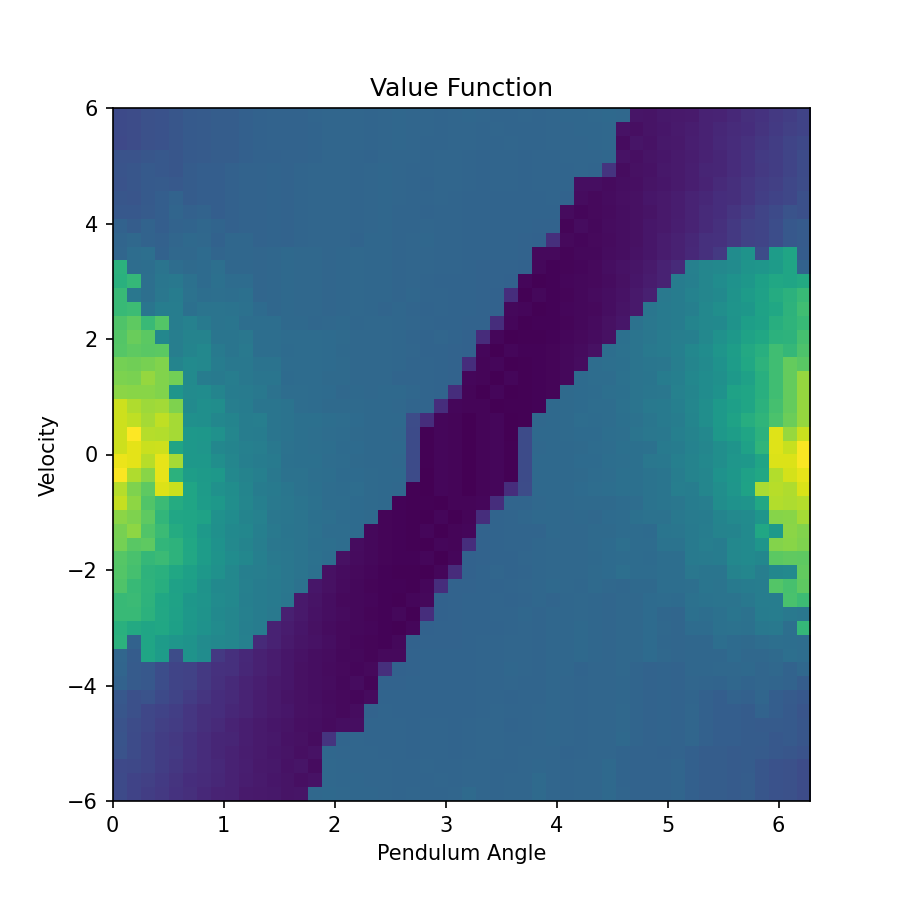

<IPython.core.display.Javascript object>


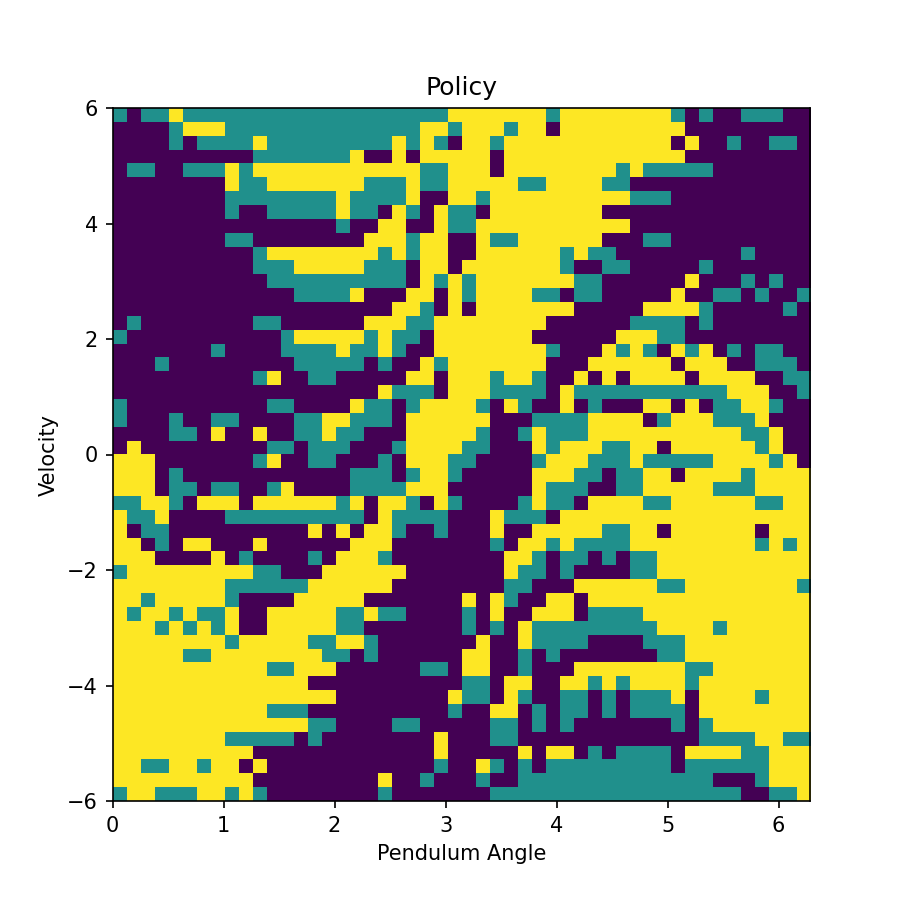

In [10]:


# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(J.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]




<IPython.core.display.Javascript object>


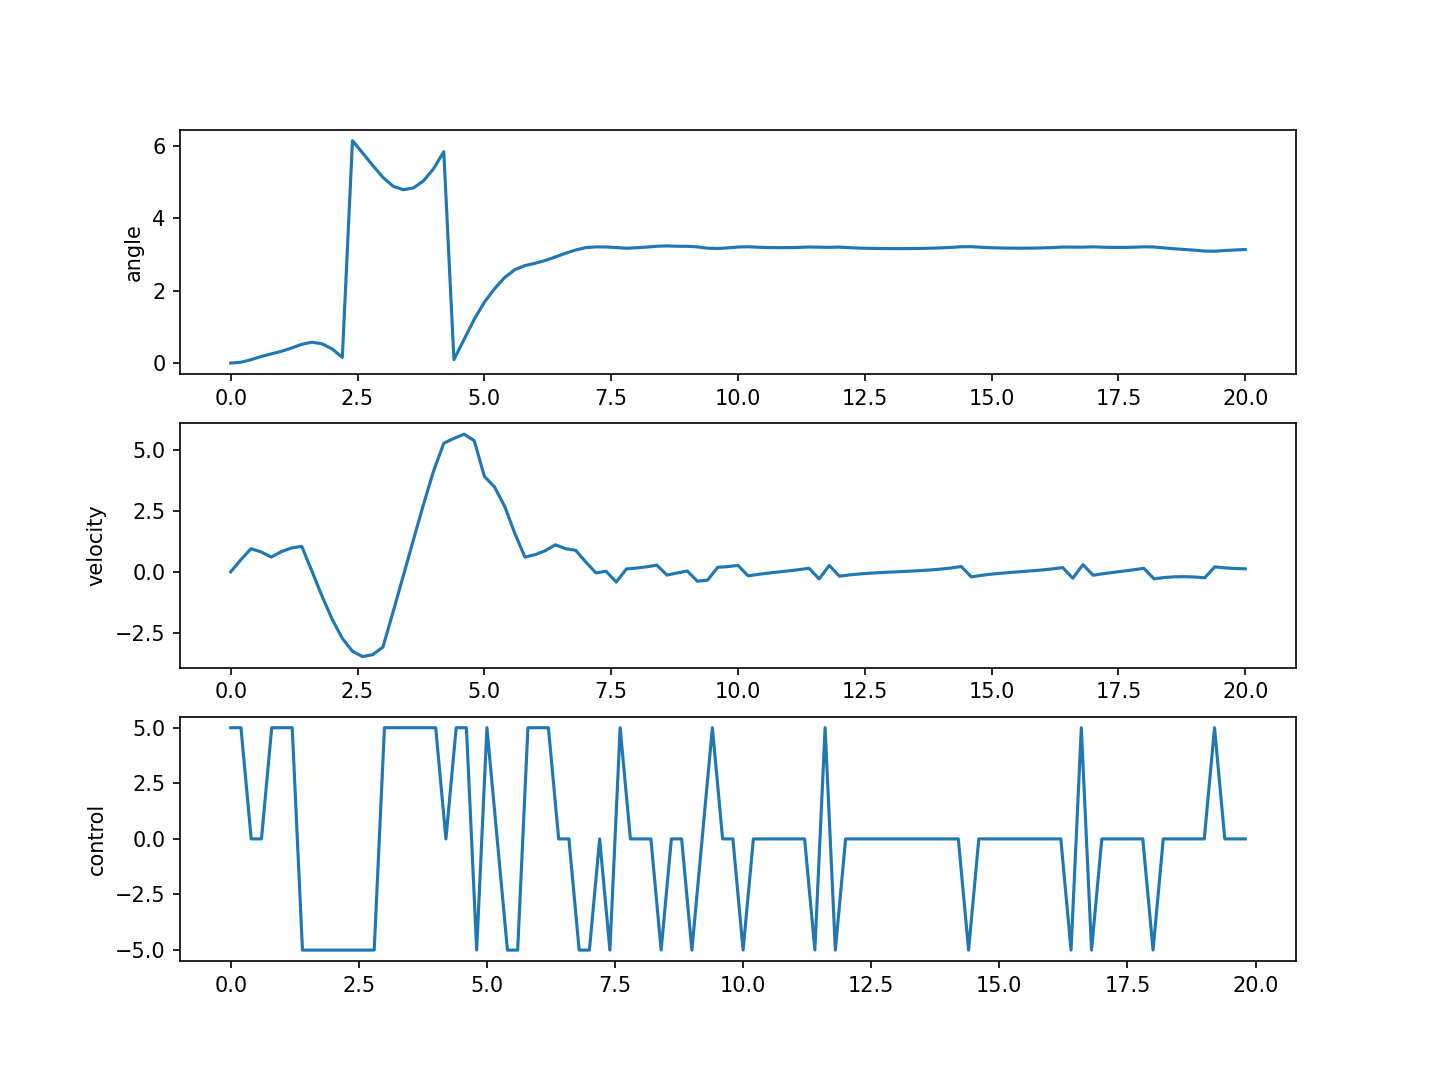

Text(0, 0.5, 'control')

In [11]:
x, u = robot.simulate(x0, controller, 10)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')

In [9]:

# and show an animation
robot.animate_robot(x, robot.delta_t)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAfc1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DRVliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zaX28uMbT6WM/MgzebP/5IgawXlFJWPgLbOX+bgXnmLrhUWxSjN3LOg4AVp4
GpLl2iUNdOEv24+I0WdswW69aIpab8sMQYo9BbKBotiaDRx+0fC427CuVpPCqyTnUBKn+gAX/8xj
yDIXb44+UHklBUWL3yDAQcoTDpE3sefTRQ4U9sUJGj2kFGltXifbADJsIu7CSHyhtgvd+57WFbDZ
rGkINclUJgrid2M2br78Wa6I16nezLC5Y4+Mg5XplCcOVZNENDUSvU5Fjc2umXdketI4v3JtltNI
lMLf8ZvD2Ct4L4VkDbV8ldY3b2loU5XObNAR21z6j6aCsOaps3mK/4YgXoG2DMw3uyw6wHLHrn2P
sg/8lT2Y98QB3tktKDfI2N9VydPYu5EcURN/pIHIPiyUrknf0Ptng9bnP4bPekLrAfdxelssXXf3
sp9XLbbIiMeLUIUtCkaIMInjZmG54L1wkOFeCTeI3gV7igTN+lGVQaHNAJYjN62pKOAaJ/OUQ27Y
4wfVO6pNQswIG7204Y3rxbPpaOmW2AnZdIaMvXzQ9yngrHVpaERBiireVuDSZjb5KLUGKllhNT/b
veeafaVf5Df7WlxAfQd5eO4W+OYkUSNL+TZCr01CJQctlSWejrH/XeT30gwHN5yHjVErMj408Uz9
VI8nAASGzqNvxU9ab/kmaaSy9SNa71QgQzqi4ZSLfU5e93blTL8CmRD5KVSUXs1z/DKCh1gcduJS
Zhf11esqswugW+3gtRleAgSgjn4/poCjoJ7+yhIppNIv+Cj3+yPdbZvNfFJzywXwyInuP68XTis9
zN2l7VKxnX39NmYGOH8TmwmNCaOe8Y+3bYH+IBjDIKJ/7OppMUe8tzkf87VUF88rY6HDk4rug3tu
NSyX+X1yrQkjnyejc8JR+yS/tunZJtjexV4fwwZ2F8RA10Wph2jUHEh1Lkf+msmAERY5dhXpPoue
xTqp0J8+YYPkvATZD63x+nOe4kPWL2mcKZjlPQQaVkMa7lgYnvJsQu1o0ku0sLpt/3aV7UXOT9l2
VdjHtGHq9ITCAXNafqwalmEMD048YI3gycDtUqf8x5APmY5yyWtuPM4N9SkbllDwtU6K299d4rlu
Jzw2pM5n5Q21ilLguKtuMJ62LL/wdchtnjZ186uj9TIQP3bkSCNt5I0IMPz8O2kzrw0kqM2YTQpf
agKp/D5WKvqXykCmSl0xZLDZrwvlmZyz9t3Ytd/eUbjCIbNvuSBvaVoaobcUh5RmA6M5Dw6D6lGA
XIVDUMNOA7rX9pAD8XC8HihtNs3WkxJ5wynIr5IcurXJ+4RwLfdGYKAAAvcw/Cj92AMhPFQo1FnN
zgAAAwAAKEAR0eoM87whTj3/5iqRB3CRuQlqycblIAHZwtGeC+lSh5GsG/4Mz2TZvYKFrW1ULhur
Pip5BX/yAeQKSHdQdzRAuN9pq6Vf8b9XR1n8Nc3UqH7u41i0wvKdIWKF1hwmql73bSszwAg5lkoH
rz88d3dADnzvVnLjNjgPo7+kdzO/zwfijydz8IB+bjZX8OP3JSMqjxxmGkXEg8J6yyjRdnHqpv0w
uDjvd6q8/w2E8VydZF6lJQgNpCqgUmowKYDzgdPhXILP9TEOqA/lvUufv1D+MRutRRmbWVK9RTTe
LQyeVAjETL50DZjcSOjhX/1TtG2YuFEOgqmS+nbHjcBQN//+TFh84gT7BHOMpTWcPX7J/0/VPh6T
SXj6A0eSZNKKghmnjN8meCTvRmqGuEa/8VJiNpit5UUyE3OomiABiCJn+msFcCHxaehNV6zliv0v
UIfyANzn4L/wEteIUp2if

## 1.3
Answer the same questions when  𝑢∈{−3,0,3}u∈{−3,0,3}

In [12]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = (x[0]-np.pi)**2 + 0.001*x[1]**2 + 0.00001*u**2
    return res
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)

In [13]:
solver = Value_iter_solver(robot,costfn=cost,actions=[-3,0,3])
J, policy = solver.value_iteration()

converge at iteration 265


<IPython.core.display.Javascript object>


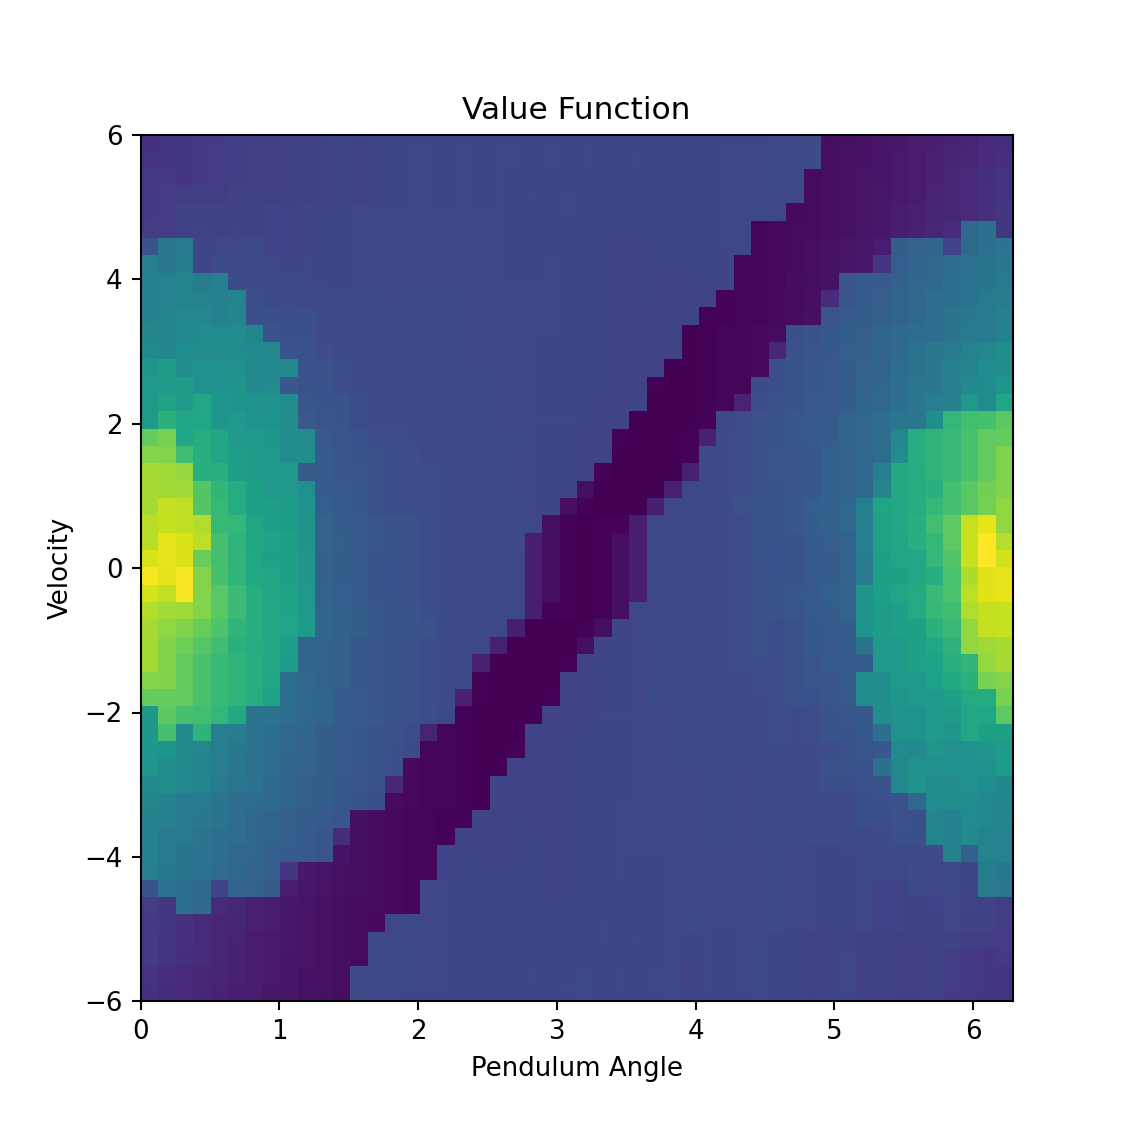

<IPython.core.display.Javascript object>


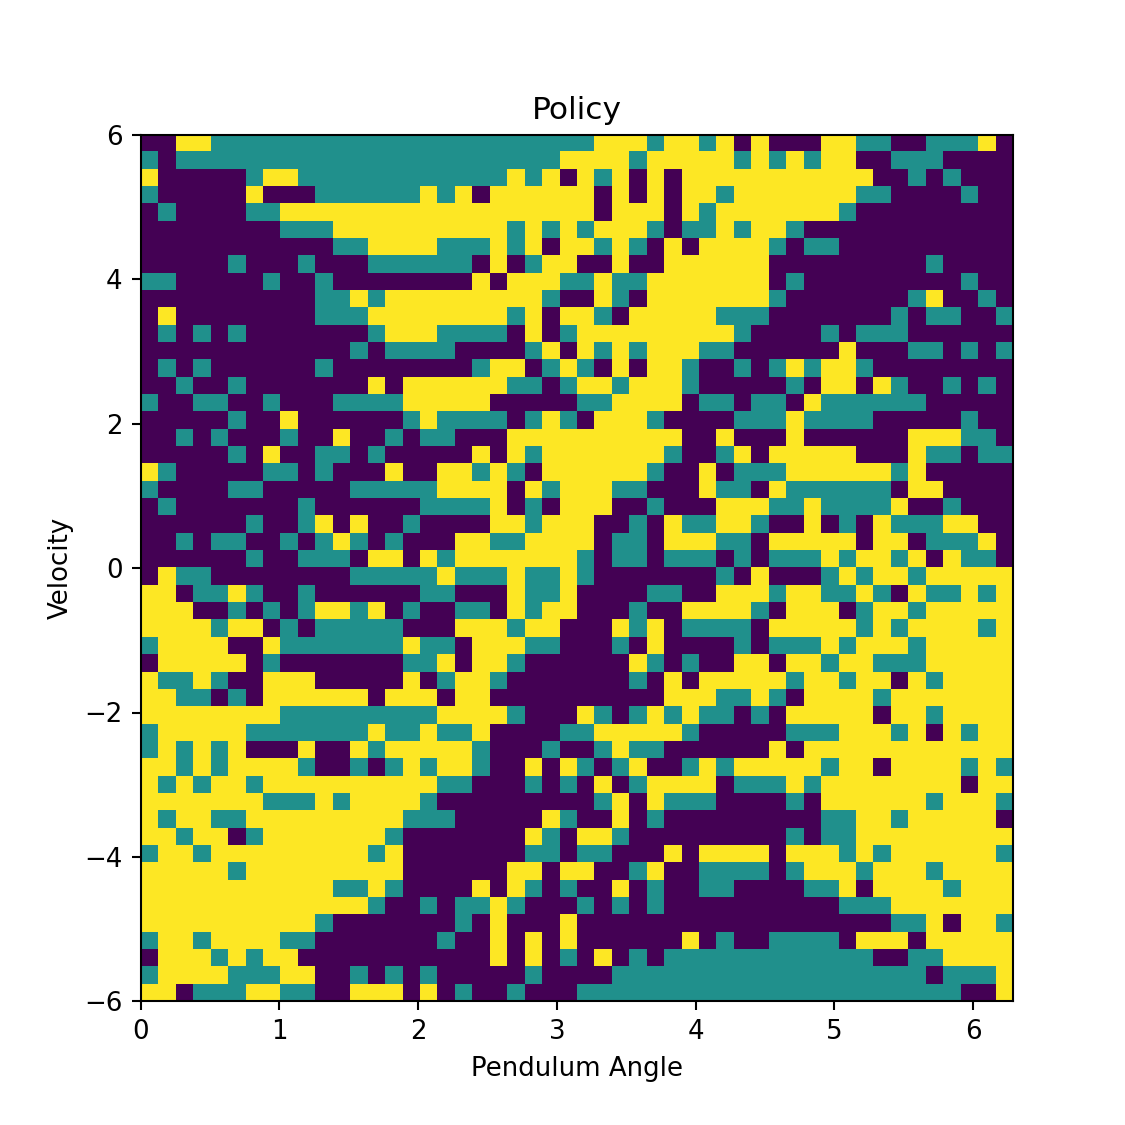

<IPython.core.display.Javascript object>


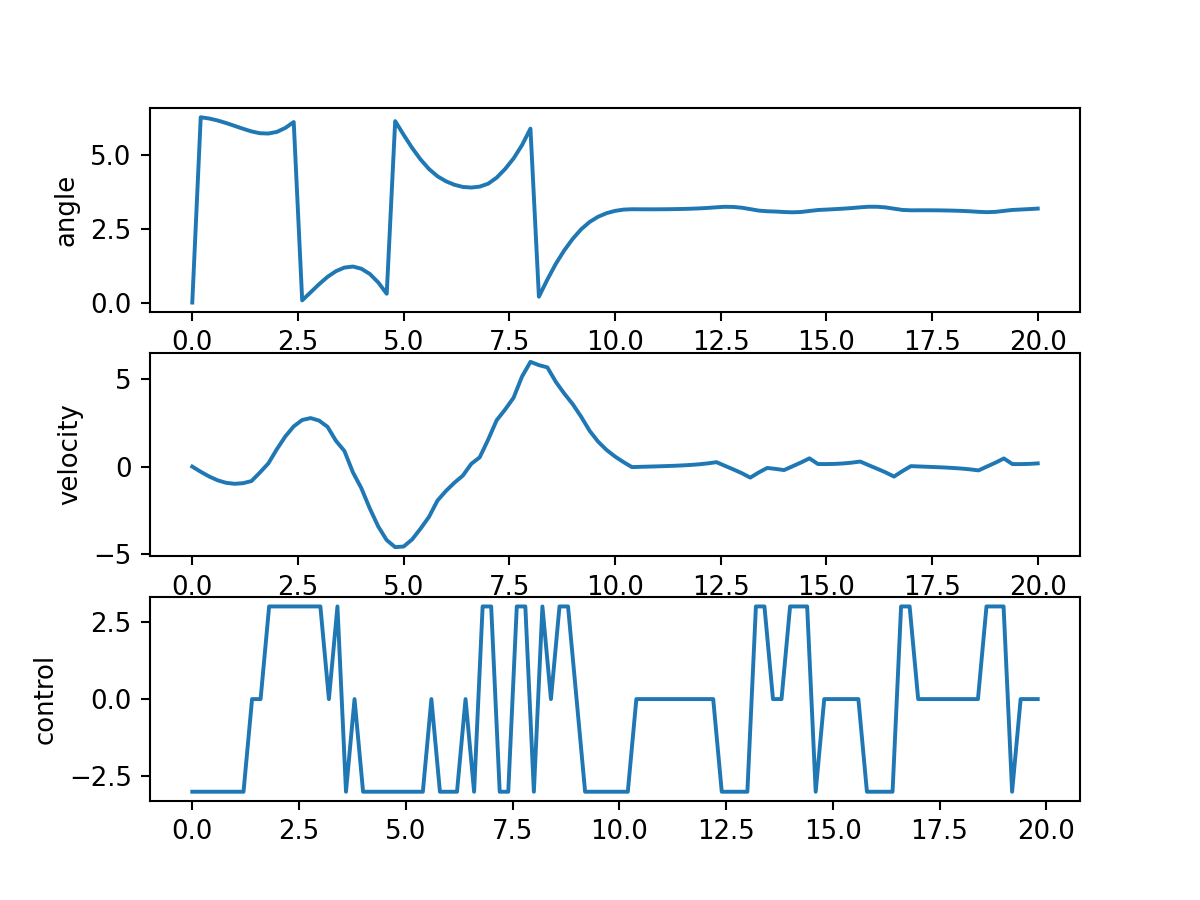

Text(0, 0.5, 'control')

In [14]:


# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(J.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]

x, u = robot.simulate(x0, controller, 10)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')


In [63]:

# and show an animation
robot.animate_robot(x, robot.delta_t)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAkDVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSFliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07ODGm3wBRMgDYiJoXlKs5BQi05q90Qvp54LHZvlABc7azzgAAAlhgo
5U0yuXoovZ93mj5c0A4kViTmwfNlFN422rrmkY0+TJXjy2QETgxH+VjLUGW4nahqUgWQqDMfnRA9
lcxOpvul0EAwcmU/0ADaLvjFil9t7FUYKNxT6HPKJl9bOWLYqE+Cy39/mB8mN+2C9yTgeLkAYVNj
W62F82r/AqVC2BbuZp4VB+J9deuuOciIUAihH1mqc5GMh8KZmyduCGi7jBcE8GKK7Ktho1WaT7h0
oHuZDvhA+oN7r4xx/LU72e6n74sxOP/4YHwYrCx4uunVofIvqDyI8tVKU7cFs6qi20OlFiEnpWYy
MuCjpARRHZRlM2GRoFbybmn+t+hpOT2kGl9eUE6pxhgP2e/K05jgu+a8wg5Gblwf9bZR5mHCGuwv
6H2yYX7Qirt1Edva6NhpS8pynYIgKubgn//x72bw3fUD/KbaGHQQ13rkfp7xuleh+4RULw7CNjk8
cMak76zfgU8a+bVEercPTo8RkWJ3mL49avNgSe+rta5nFjYld61LaYm72pYYEWFAeMQ+c8MiAqOI
M8S1FaLdhrk4Le9mWFyhTXA7IGRdk4cqyaIcHFKCKp+nRGeiEOBY4BuAzzk7XuFOpvxftQ2KMBWT
gsxtGS0dcPwdMyAcW6L9r1AgE+v0Trrt4F1whrlf9PPeoRdRrKIYrMFxn7otleh8cf24ItIdm/S3
2RBCTMxFlF99iSo76oWnGIpH8k044UXFaiPq/ynJLPGbn/DZ70hdYD7uL0rZrKKew4Qq/Jpj4K16
4xmX4FMIZIOLzVc/BCgmaLivt7Oo/pHuSGxWRfzq6tqg5ZV1bR+/EA01LuhEAKhP814u05q25bhH
bVYR53/aiO9W5v2UtGismjs9+LkusDo6eLf/At5MOJfPALjRa6ZieHtyDFColwmCwaASmCcxLPT9
NaKfl2/QFsfu0qfJKGQnO77Gkj3YS2R+JotKXe61xGlNHtFi+0BO8VIC5k6WLpHuCaZnxO5pBJx7
7jZHswNMspoWZU0YaP/MD6pC+r3pQ0jLDtMdJ286aY8hMZeAQByWyK2CFOOc9on5i8ovUKZV4eW8
FYM1TOTrlB2M0ZiCZK0b5/yE6a6snLVFT5HzKuDFI/+RLcv5uK9dHbj06dFYlGtg0IdfKL9lT3jH
LNxqyFy2FWdHNaLaYi8Bm5HG4wZKAxzT3oqa1PYnjZjmijfmILjYo41Hx9qLi0PqIY+wrhLerLW3
sVvpWN++ASRz5PRue2r/8C7/mizYYzSlmG2UlMFnl18lzCyQqGUmoa9o5wGxw5i71SLsq2R0u+DP
fdiv7aLc337PAyokE0WTkorWD/GbgWmbZR0yPRA/YCFMk709bCH4/WyCZ3N5kWhoN20FhmAHNZOG
jNASDf59rWEb/ArN5FC6MIZ3eGXqVmIvW04ofJXw8rxDoxdqjc7SY60VZLMDatPXuagq2CtBGntV
7XYv2pHBLOng3glcbf+1m2ouCvGvLyjcxefh2+FLp5UcKVpjrqy0dJnXho5K8EApOftt1t4h7x/C
YxDflQwfIcRt6KkKM30/GS6dKcMf8IZkhxkTtTUVREcW5HLg/7kCwyaFHf+yumESaieZl+P83xwu
mAxngKHtqP6hRJ6aAvu4R217sV3PFSEDsQXuj68QCW4ACG9Z7DCAYOk4at9p/iboOwcNEIAAfvXF
W3RX7XwY0r+yQDaAAAHTAue1UdjihUhVx/1kXsS/KOEj47VhBAM2/XkcGMxtLCz3kx6njxNNEsY7
hNR0oeijW4no+KrnDt590vfGzRr0PTtH9i7qhzD+DraP4N67+Afz1Fp7rLmefDHceDHVS0bdJEUs
69FlSjFyL9s9sjacQ52V8ieA9ijFDIdtf6DrviPpO8A02y2iqv4jBpy23Cem0PA+N4kZN55so3+G
wniuRUhdOcKEBtIVUCk1GBVkkdlrMDd1Wxryv7uV9qKSup6h/GI3WoozO6qxyRvj+LQyeVBb1hyF
vM8xe6qdEc/6p2t2U1ufYnChz2vNuvL13oCP80PYRjdJUEu9trs77WzG+klP1T4ek0l4+gZdRl8b
0MJm5w7F5hWJyGY1nLcf6wGYrbGDih9SH/t3uMVxe+gftKFOUAh1RnHMq0wBcEblsn50Bsfru/dE
iO093awNIE0YQsZ5iVFUD

## Q1.4
4. Answer the same questions when $u \in \{-5, 0 ,5\}$ and we use a "sparse" cost function, i.e. a cost function where every state apart from the states close to being inverted have the same cost $g(x,u) = \left\{ \begin{array}{l} 0 \quad \textrm{if } |\theta - \pi| < 0.2 \\ 1 \quad \textrm{otherwise} \end{array} \right.$


In [15]:
def cost(x,u):
    theta = x[0]
    theta_dot = x[1]
    res = 0 if abs(theta-np.pi)<0.2 else 1
    return res
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)

In [16]:
solver = Value_iter_solver(robot,costfn=cost,actions=[-5,0,5])
J, policy = solver.value_iteration()

converge at iteration 25


<IPython.core.display.Javascript object>


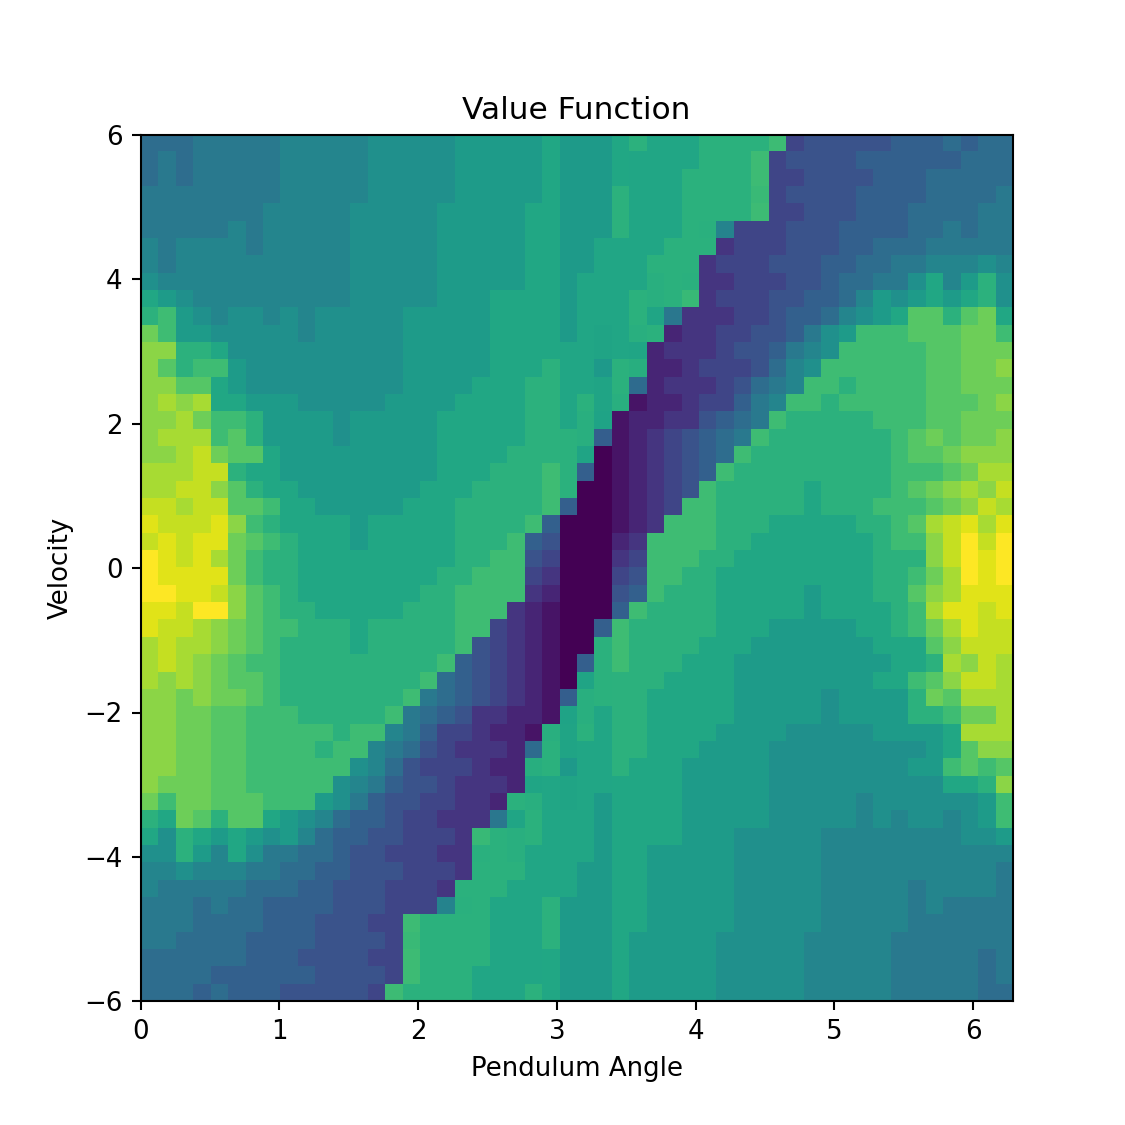

<IPython.core.display.Javascript object>


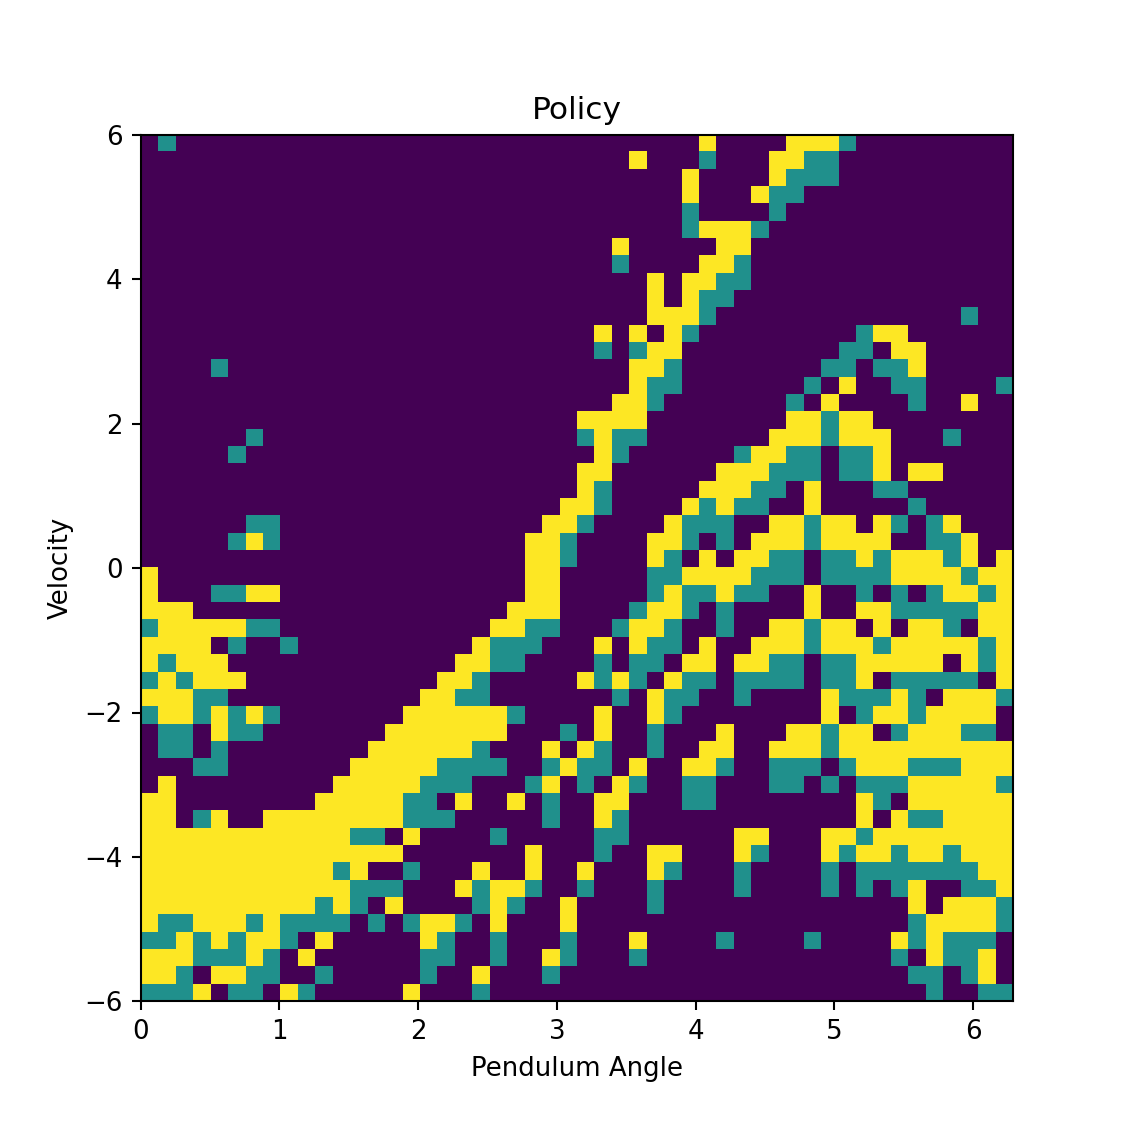

<IPython.core.display.Javascript object>


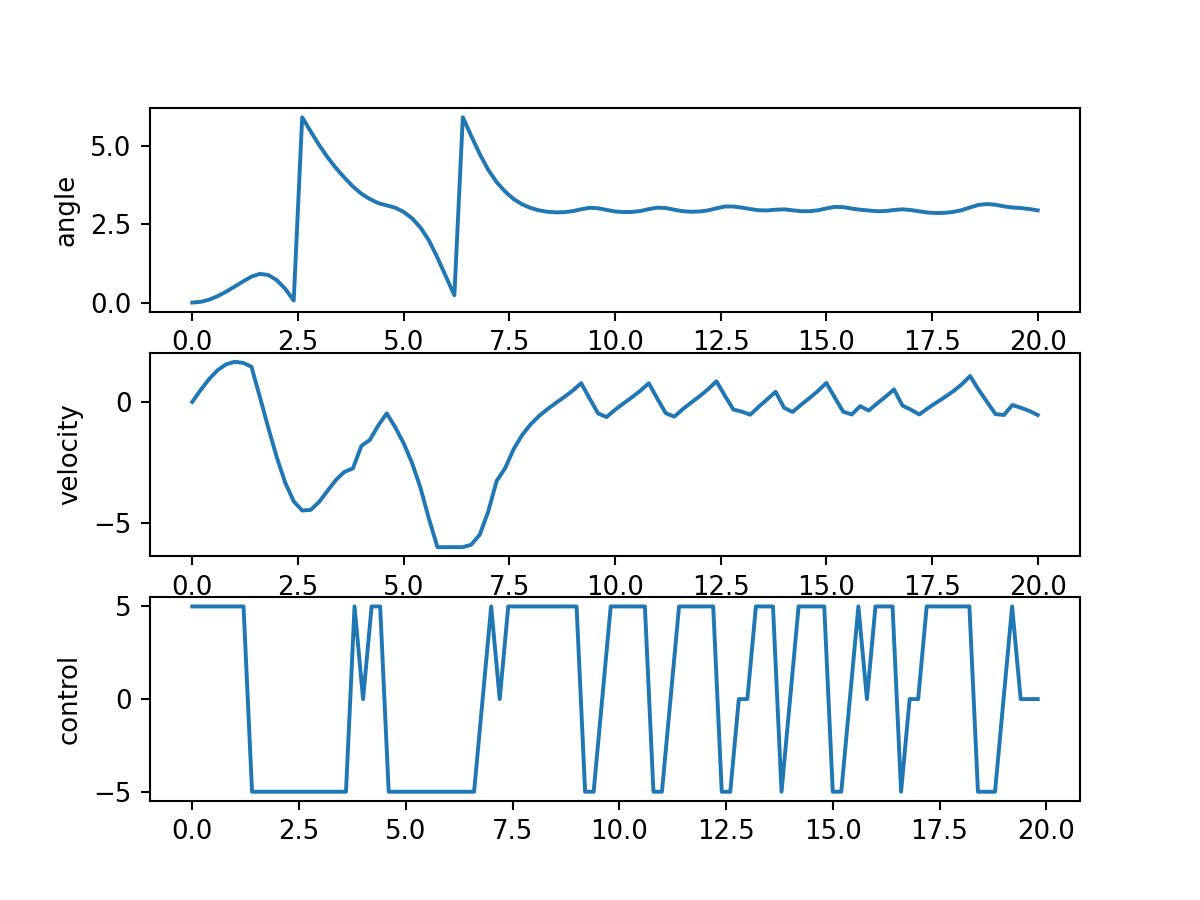

Text(0, 0.5, 'control')

In [17]:


# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(J.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy.T, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]

x, u = robot.simulate(x0, controller, 10)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')


In [59]:

# and show an animation
robot.animate_robot(x, robot.delta_t)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAmVttZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQFliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzPrTxQ6iH
cJiRo0fW0kYXJDKfann1P7TPVfS9dC0PyNj2pJMQhijbyTPh/kspy09TkM1gkRg/OaisIqxqlLbr
4GQt2/YAOvSxOL+prV10KxzWeUmVfl/K0iYnBhU3n/Uwd4ACyxBU3TPL+qMpqqZsuuJJfihIGfgt
9jz5F3T3ztnJYJHVf+9Gb2sR30D/NKuHv0nd33mjLmT9Jl8Evc4KKuUHMT0s6ib53vuaVSoAAAMA
ABf8CBkTPl0rl6KMDDekdahTNS3vw8bwjbulzZ+0M9c0jGnyZK8eWyXcFuGqLC+egkR32tUPSBZC
oMxH1LUcxQrNbwOYgnqJODn9AA2i74xX1k0kkQ4OFx4Bb1n/IXWByxbFQnwWW/vpZPff4HKak3aX
i41WdZr1uthfNq/wEK9My8QglGFQfieykz5jnIiFAIoRbblhkOXiLceM2TNBykXcYLgngxRXRhRn
sD3eiJxlA9zId8IH1BvdfGOP5anez3U/fFmJM/9hCJLcmYPgeaJlpvxl+yiEyLV406i5ir7DVDpR
Yg/3XRnn1BsYLF/QABiNNyThjFrz8GlSCQBwdYlrqlcz9SJDFVDqWzTU9vCKMEyMo0IUMzGs2/HQ
8RPDWjgE0ltzWubTVNo1elOidKSvscpDzYTOUH/+/S8/yJcjqIIaaG2b34Qcu9JK9gzA0hQe3VG0
sMXAKvY4dRBGNfHun/i9Iw2Jns+q2dIUh87Z6t7e+Hkz1QnTNyb3OJEYpJPesVOiFm4D2GBFhQHh
sUcORgI4aRMl5Shtpm03ScFvezLC5Q8jgdkDIuycOVZNEOF0BBFU/TojPRCHBe74j+twidr3CnUQ
iG4Z09iyMqVbcxbSGj0HYdMyAcW6L9r1DvNKqkRGAIoyxHBtb/9yHVoRdQc27tI3biy4Wef7xghi
MnMrRkd8ZBCLV3ptzYy8v+baW/rwSxigT+xgW+S9qcnnCLR/s91fUhbaub450C+w7S5cou1NqEbD
DvTTp8FHvgY1snXbQuCqf5Lk2guh4LqdeQKuR/8+kM46l+AggprpmZsAAAMCwoptvYHqdv1cxCLE
/AFCYVZeZ3VIGtpFceu8I4+4bC7JXXvio9jZfgObhawLxBIDzPVVLQmsHb4ABPVSaKQyWqqbvdp/
srkEIq6DJjgHfn+vuOMCGR9r8jRAIZLmSavqUrsUt5o2jUO4d25yhjad9m7C67BO8txw1FUZ62mI
PQHvqJoimKlj8tq/tIsVq1GOifUcUAFXueIEY3+2yA+f+FZzzszNxkagkkeEEJwrWeFSLbMnavYm
gWag9nI8GVkhQPhCYCBfjiCa7ypvFGlMmEhOw9/WFfen/wEbin3uy55NDPTp0ViUa2DQh7telsy7
Aee6puNaku51WdHNaLaYi8Bmv0exZsnQPYspvuXGOwyjqKgUqLes33Yo43jRL8Li0PqIY+wwzoAD
DW3sVvpWN++ASRz5PRuext/9I8fKizYdVghg9rKSmCzy/bc5hZIVDKTUNexOHDY5wxd6pF2VbJsZ
B3Z2uxX9tFub9JPSHTj4MHmbrN910c2+GmbZR0yPRCoBKFMk709bCH5/awT96cuqBmkuIRl2Rnsu
3jGX6RYv6ju7PjCDCIJmtvj1bPRw9H45zzrR4bjPUr7326/koBFQ3Otb+QEFMZpMmN8ktMu1HxDb
Bcw0/mLqjLZ2zNPPjd8YP/7WrRi77Mi9/Oj4A0u7tyIpjZnZruY66stHSZ14Z2CcOwKTiJieGDlr
h9GVEV8e4/rWYQTQTivuEprlHHh0yIjb8roorEpBi+qEgEfg/98HoiuhHmy4ocu2l0D5Hj4dvx1Q
hYINNcK2RiisbkAEN6oswq0y6hzF/C0O5cj89teMyZOJdSi/GdQAAOZZ6n9XQwACUXQwKeAAAAQV
zPbOx7rxCELBbMulFwfi8mlM70f6yL2JflHEY77JZchE2w4LKDGY2lhZ7yY9Tx79gCzq+G2N/Sol
lIrkk/pqEBi0KxehqJn26f3hlYLuKcJOxo3Co0wDYV+oof8YvgBBzLJQR9lQ7Izf9IXwaDqo2ZF6
WSgD57WU87na2B3UMKKF1K+qAEOPag0HOXbwJv5No42H9M5jKqNVsfL3xAcMRKB083aEqBzu0Hbh
VQm/CFCA2kKqBSajAqiWupszw3dVrmAKdUB/Leo6HfqH8YjdaijM6FDHJG+P4tDJ5UHMk9HaLftg
c8SIUab9XQmB74UQ6CqZL6dseNwFA4v/JEjbvO6fWj+rllR/C3hRSEuf8ueIkL41ApEnZrLgSGJP
nM28CanIZjWcpH/ql5RRYI6NhCpdzPDDDGI+6EKGliifobSIrc6vPK/nZ05ZI5u9Xgg4DwTksIa5
jxdeW4bUwiAUXaYHWtmeb